# TS2Vec sur ECG5000 — Evaluation
- Rechargement d'un run existant (EXP_ID choisi à la main)
- Extraction des représentations + logistic regression
- Affichage accuracies + quelques plots

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import models as m

from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Paths + run à recharger

In [2]:
CURR_DIR = Path.cwd()
CURR_DIR_PARENT = list(CURR_DIR.parents)
SRC_DIR = CURR_DIR_PARENT[0]

DATA_DIR = SRC_DIR/ "data"
DATASET_DIR = DATA_DIR / "ECG5000"
train_path = DATASET_DIR / "ECG5000_TRAIN.ts"
test_path  = DATASET_DIR / "ECG5000_TEST.ts"

RUNS_DIR = CURR_DIR/"runs"

EXP_NAME = "ecg5000"

EXP_ID = "0"  

EXP_DIR = RUNS_DIR / EXP_NAME / EXP_ID
print("EXP_DIR:", EXP_DIR)

config_path = EXP_DIR / "config.json"
state_dict_path = EXP_DIR / "encoder.pt"

assert config_path.exists(), f"{config_path} not found"
assert state_dict_path.exists(), f"{state_dict_path} not found"

with open(config_path, "r") as f:
    config = json.load(f)

print("Config load:")
print(config)

EXP_DIR: /Users/rplanchon/Documents/MVA/Cours/S1/TimeSeries/Proj/T2SVEC/src/first_Imple/runs/ecg5000/0
Config load:
{'dataset': 'ECG5000', 'in_channel': 1, 'representation_dim': 320, 'num_blocks': 10, 'kernel_size': 3, 'lr': 0.0001, 'batch_size': 8, 'n_epoch': 500, 'alpha': 0.5, 'temporal_unit': 0, 'use_instance_loss': True, 'use_time_loss': True}


## Data 

In [3]:
X_train, y_train = load_from_tsfile_to_dataframe(str(train_path))
X_test,  y_test  = load_from_tsfile_to_dataframe(str(test_path))

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)
print("Example series shape:", X_train.iloc[0, 0].shape)

def df_to_numpy(X):
    arr = np.stack([X.iloc[i, 0] for i in range(len(X))], axis=0)
    return arr[..., np.newaxis]  # (N, T, 1)

X_train_np = df_to_numpy(X_train)
X_test_np  = df_to_numpy(X_test)

X_train_torch = torch.from_numpy(X_train_np).float()
X_test_torch  = torch.from_numpy(X_test_np).float()
y_train_torch = torch.from_numpy(y_train.astype(np.int64))
y_test_torch  = torch.from_numpy(y_test.astype(np.int64))

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

train_eval_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_eval_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

X_train shape: (500, 1)
X_test shape : (4500, 1)
Example series shape: (140,)


## Modèle laoding

In [4]:
device = "mps" if torch.mps.is_available() else "cpu"
print("Device:", device)

model = m.Encoder(
    in_channel=config["in_channel"],
    representation_dim=config["representation_dim"],
    num_blocks=config["num_blocks"],
    kernel_size=config["kernel_size"],
)
model.load_state_dict(torch.load(state_dict_path, map_location=device))
model.to(device)
model.eval()

total = sum(p.numel() for p in model.parameters())
print(f"Total params: {total/1e6:.2f} M")

Device: mps
Total params: 6.15 M


In [5]:
loss_path = EXP_DIR / "train_loss.npy"
if loss_path.exists():
    log_np = np.load(loss_path)
    plt.figure()
    plt.plot(log_np)
    plt.yscale("log")
    plt.title("Training loss (reloaded)")
    plt.xlabel("Iteration")
    plt.ylabel("HierLoss")
    plt.grid(True)
    plt.show()
else:
    print("No train_loss.npy found at", loss_path)

No train_loss.npy found at /Users/rplanchon/Documents/MVA/Cours/S1/TimeSeries/Proj/T2SVEC/src/first_Imple/runs/ecg5000/0/train_loss.npy


## Extraction des représentations + logistic regression

In [6]:
@torch.no_grad()
def extract_representations(dataloader, model, device):
    zs = []
    ys = []
    for x, y in dataloader:
        # x: (B, T, 1) -> (B, 1, T)
        x = x.to(device).permute(0, 2, 1)

        r = model(x)  # (B, K, T)

        
        z = r.max(dim=-1).values # max pooling
      
        zs.append(z.cpu())
        ys.append(y.cpu())

    Z = torch.cat(zs, dim=0).numpy()   # (N, K)
    y = torch.cat(ys, dim=0).numpy()   # (N,)
    return Z, y

Z_train, y_train_np = extract_representations(train_eval_loader, model, device)
Z_test,  y_test_np  = extract_representations(test_eval_loader,  model, device)

print("Z_train / Z_test shapes:", Z_train.shape, Z_test.shape)

Z_train / Z_test shapes: (500, 320) (4500, 320)


In [7]:
clf = LogisticRegression(
    max_iter=1000,
    multi_class="auto"
)
clf.fit(Z_train, y_train_np)

y_pred_train = clf.predict(Z_train)
y_pred_test  = clf.predict(Z_test)

acc_train = accuracy_score(y_train_np, y_pred_train)
acc_test  = accuracy_score(y_test_np,  y_pred_test)

print(f"Train accuracy: {acc_train:.4f}")
print(f"Test  accuracy: {acc_test:.4f}")

Train accuracy: 1.0000
Test  accuracy: 0.9313


/Users/rplanchon/.venvs/time-series/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


## Visualisation rapide des features

out shape: torch.Size([32, 320, 140])
x_batch shape: torch.Size([32, 140, 1])


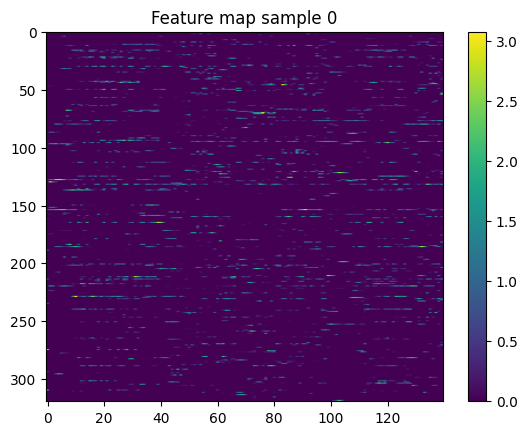

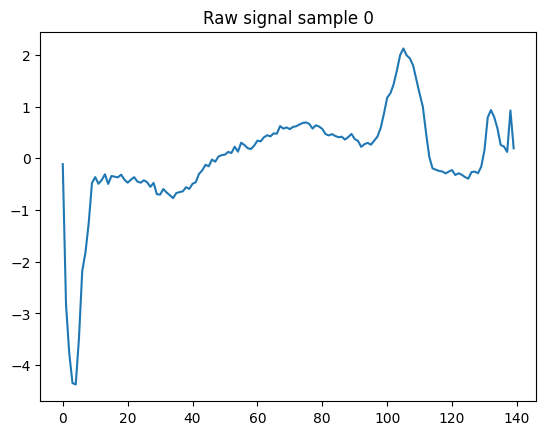

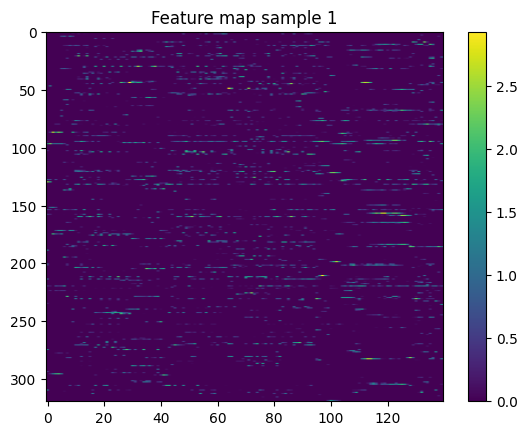

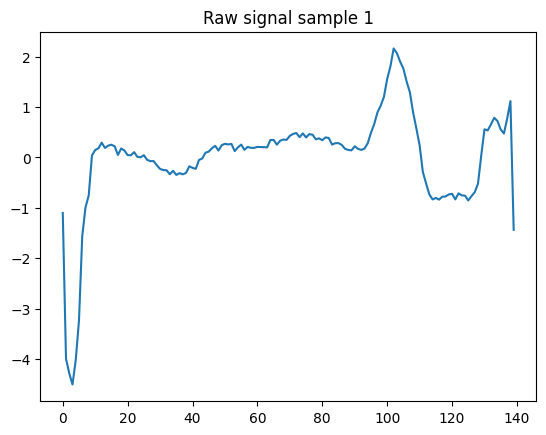

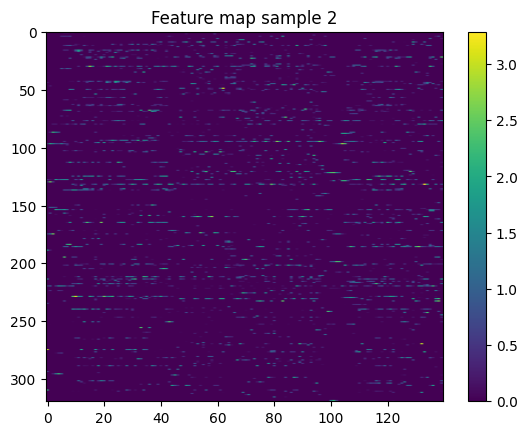

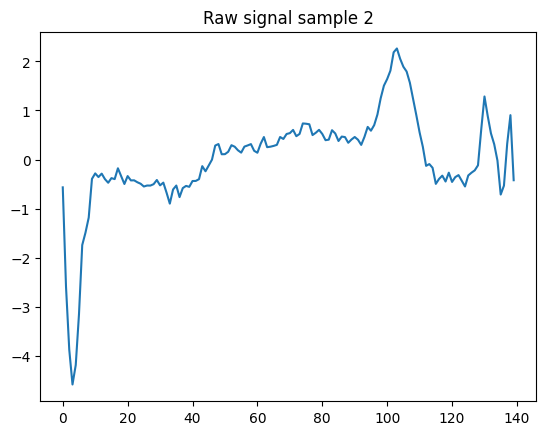

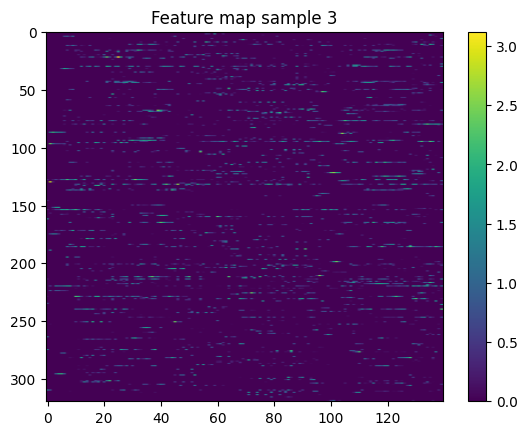

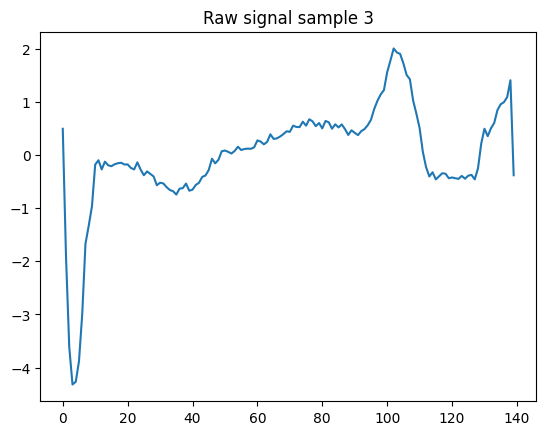

In [8]:
iterative = iter(train_eval_loader)
x_batch, _ = next(iterative)
x_batch = x_batch.to(device)
out = model(x_batch.permute(0, 2, 1))
B, _, _ = out.shape
print("out shape:", out.shape)
print("x_batch shape:", x_batch.shape)

for j in range(min(B, 4)):
    plt.figure()
    plt.imshow(out[j].squeeze().cpu().detach(), aspect="auto")
    plt.colorbar()
    plt.title(f"Feature map sample {j}")
    plt.show()

    plt.figure()
    plt.plot(x_batch[j].view(-1).cpu().detach())
    plt.title(f"Raw signal sample {j}")
    plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
device = 'cpu'
model.to(device)
model.eval()

def extract_representations(dataloader, model, device, pool="mean"):
    zs = []
    ys = []
    with torch.no_grad():
        for x, y in dataloader:
            # x: (B, T, 1)  (B, 1, T)
            x = x.to(device).permute(0, 2, 1)

            r = model(x)  # (B, K, T)

            if pool == "mean":
                z = r.mean(dim=-1)      # (B, K)
            elif pool == "max":
                z = r.max(dim=-1).values
            else:
                raise ValueError("pool must be 'mean' or 'max'")

            zs.append(z.cpu())
            ys.append(y.cpu())

    Z = torch.cat(zs, dim=0).numpy()   # (N, K)
    y = torch.cat(ys, dim=0).numpy()   # (N,)
    return Z, y


train_eval_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_eval_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

Z_train, y_train_np = extract_representations(train_eval_loader, model, device, pool="max")
Z_test,  y_test_np  = extract_representations(test_eval_loader,  model, device, pool="max")

print(Z_train.shape, Z_test.shape)  


(500, 320) (4500, 320)


In [10]:
clf = LogisticRegression(
    max_iter=1000,
    multi_class="auto"
)
clf.fit(Z_train, y_train_np)

y_pred = clf.predict(Z_test)
acc = accuracy_score(y_test_np, y_pred)
print("Test accuracy:", acc)


Test accuracy: 0.9315555555555556


/Users/rplanchon/.venvs/time-series/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
